In [32]:
import argparse
import os
import torch
from exp.exp_main import Exp_Main
import random
import numpy as np
os.environ['CUDA_VISIBLE_DEVICES'] ='0'
parser = argparse.ArgumentParser(description='Autoformer & Transformer family for Time Series Forecasting')

# random seed
parser.add_argument('--random_seed', type=int, default=2021, help='random seed')

# basic config
parser.add_argument('--is_training', type=int,  default=1, help='status')
parser.add_argument('--model_id', type=str,  default='test', help='model id')
parser.add_argument('--model', type=str,  default='MSPTST',
                    help='model name, options: [Autoformer, Informer, Transformer]')

# data loader
parser.add_argument('--data', type=str,  default='ETTh1', help='dataset type')
parser.add_argument('--root_path', type=str, default='/ssddata/data/jiahuili/PatchTST/all_six_datasets/ETT-small/', help='root path of the data file')
parser.add_argument('--data_path', type=str, default='ETTh1.csv', help='data file')
parser.add_argument('--features', type=str, default='M',
                    help='forecasting task, options:[M, S, MS]; M:multivariate predict multivariate, S:univariate predict univariate, MS:multivariate predict univariate')
parser.add_argument('--target', type=str, default='OT', help='target feature in S or MS task')
parser.add_argument('--freq', type=str, default='h',
                    help='freq for time features encoding, options:[s:secondly, t:minutely, h:hourly, d:daily, b:business days, w:weekly, m:monthly], you can also use more detailed freq like 15min or 3h')
parser.add_argument('--checkpoints', type=str, default='/ssddata/data/jiahuili/PatchTST/checkpoints/', help='location of model checkpoints')

# forecasting task
parser.add_argument('--seq_len', type=int, default=336, help='input sequence length')
parser.add_argument('--label_len', type=int, default=0, help='start token length')
parser.add_argument('--pred_len', type=int, default=720, help='prediction sequence length')


# DLinear
#parser.add_argument('--individual', action='store_true', default=False, help='DLinear: a linear layer for each variate(channel) individually')

# PatchTST
parser.add_argument('--fc_dropout', type=float, default=0.3, help='fully connected dropout')
parser.add_argument('--head_dropout', type=float, default=0.0, help='head dropout')
parser.add_argument('--patch_len', type=int, default=16, help='patch length')
parser.add_argument('--stride', type=int, default=8, help='stride')
parser.add_argument('--padding_patch', default='end', help='None: None; end: padding on the end')
parser.add_argument('--revin', type=int, default=1, help='RevIN; True 1 False 0')
parser.add_argument('--affine', type=int, default=0, help='RevIN-affine; True 1 False 0')
parser.add_argument('--subtract_last', type=int, default=0, help='0: subtract mean; 1: subtract last')
parser.add_argument('--decomposition', type=int, default=0, help='decomposition; True 1 False 0')
parser.add_argument('--kernel_size', type=int, default=25, help='decomposition-kernel')
parser.add_argument('--individual', type=int, default=0, help='individual head; True 1 False 0')

# Formers 
parser.add_argument('--embed_type', type=int, default=0, help='0: default 1: value embedding + temporal embedding + positional embedding 2: value embedding + temporal embedding 3: value embedding + positional embedding 4: value embedding')
parser.add_argument('--enc_in', type=int, default=7, help='encoder input size') # DLinear with --individual, use this hyperparameter as the number of channels
parser.add_argument('--dec_in', type=int, default=7, help='decoder input size')
parser.add_argument('--c_out', type=int, default=7, help='output size')
parser.add_argument('--d_model', type=int, default=128, help='dimension of model')
parser.add_argument('--n_heads', type=int, default=8, help='num of heads')
parser.add_argument('--e_layers', type=int, default=3, help='num of encoder layers')
parser.add_argument('--d_layers', type=int, default=1, help='num of decoder layers')
parser.add_argument('--d_ff', type=int, default=256, help='dimension of fcn')
parser.add_argument('--moving_avg', type=int, default=25, help='window size of moving average')
parser.add_argument('--factor', type=int, default=1, help='attn factor')
parser.add_argument('--distil', action='store_false',
                    help='whether to use distilling in encoder, using this argument means not using distilling',
                    default=True)
parser.add_argument('--dropout', type=float, default=0.3, help='dropout')
parser.add_argument('--embed', type=str, default='timeF',
                    help='time features encoding, options:[timeF, fixed, learned]')
parser.add_argument('--activation', type=str, default='gelu', help='activation')
parser.add_argument('--output_attention', action='store_true', help='whether to output attention in ecoder')
parser.add_argument('--do_predict', action='store_true', help='whether to predict unseen future data')

# optimization
parser.add_argument('--num_workers', type=int, default=10, help='data loader num workers')
parser.add_argument('--itr', type=int, default=1, help='experiments times')
parser.add_argument('--train_epochs', type=int, default=100, help='train epochs')
parser.add_argument('--batch_size', type=int, default=128
                , help='batch size of train input data')
parser.add_argument('--patience', type=int, default=5, help='early stopping patience')
parser.add_argument('--learning_rate', type=float, default=0.001, help='optimizer learning rate')
parser.add_argument('--des', type=str, default='test', help='exp description')
parser.add_argument('--loss', type=str, default='mse', help='loss function')
parser.add_argument('--lradj', type=str, default='type3', help='adjust learning rate')
parser.add_argument('--pct_start', type=float, default=0.3, help='pct_start')
parser.add_argument('--use_amp', action='store_true', help='use automatic mixed precision training', default=False)

# GPU
parser.add_argument('--use_gpu', type=bool, default=True, help='use gpu')
parser.add_argument('--gpu', type=int, default=0, help='gpu')
parser.add_argument('--use_multi_gpu', action='store_true', help='use multiple gpus', default=False)
parser.add_argument('--devices', type=str, default='0,1,2,3', help='device ids of multile gpus')
parser.add_argument('--test_flop', action='store_true', default=False, help='See utils/tools for usage')

parser.add_argument('--scale', type=int, default=5, help='scale')
parser.add_argument('--gate', type=int, default=1, help='gate')
parser.add_argument('--channel_dependent', type=int, default=0, help='gate')
parser.add_argument('--group', type=int, default=1, help='scale')

parser.add_argument('--cuda_devices',type=str,default='0')

#crossfromer

parser.add_argument('--win_size',default=2)
args,unkown = parser.parse_known_args()

In [33]:
import torch
from models.MSPTST import Model
model = Model(args).float().to('cuda:0')
model.load_state_dict(torch.load('/ssddata/data/jiahuili/PatchTST/checkpoints/ETTh1.csv_test_MSPTST_ETTh1_ftM_sl336_ll0_pl720_dm128_nh8_el3_dl1_df256_fc1_ebtimeF_dtTrue_test_0_scale5_gate1/checkpoint.pth'))
model.eval()

Model(
  (model): MSPTST_backbone(
    (revin_layer): RevIN()
    (backbone): ModuleList(
      (0): TSTiEncoder(
        (W_P): Linear(in_features=16, out_features=128, bias=True)
        (dropout): Dropout(p=0.3, inplace=False)
        (encoder): TSTEncoder(
          (layers): ModuleList(
            (0): TSTEncoderLayer(
              (self_attn): _MultiheadAttention(
                (W_Q): Linear(in_features=128, out_features=128, bias=True)
                (W_K): Linear(in_features=128, out_features=128, bias=True)
                (W_V): Linear(in_features=128, out_features=128, bias=True)
                (sdp_attn): _ScaledDotProductAttention(
                  (attn_dropout): Dropout(p=0.0, inplace=False)
                )
                (to_out): Sequential(
                  (0): Linear(in_features=128, out_features=128, bias=True)
                  (1): Dropout(p=0.3, inplace=False)
                )
              )
              (dropout_attn): Dropout(p=0.3, inplace=False

test 2161
0.6773676
0.3667775
0.6583818
0.3208732
0.587944
0.32169282
0.2508636
(128, 720, 7)


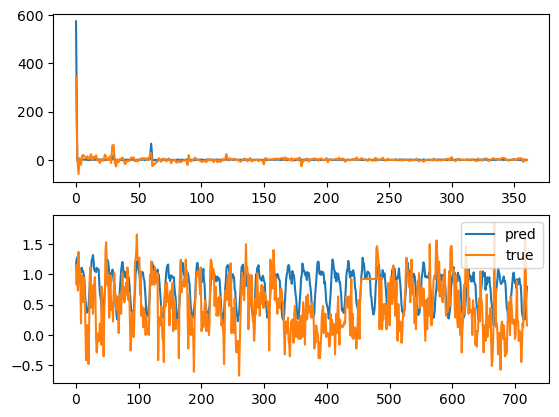

In [44]:
from data_provider.data_factory import data_provider
import matplotlib.pyplot as plt
from statistics import mean
test_data, test_loader = data_provider(args,flag='test')
%matplotlib inline
import numpy as np
from numpy import save
preds=[]
trues=[]
with torch.no_grad():
            for i, (batch_x, batch_y, batch_x_mark, batch_y_mark) in enumerate(test_loader):
                # (batch_x, batch_y, batch_x_mark, batch_y_mark) =next(iter(test_loader))
                
                
                
                batch_x=batch_x.float().to('cuda:0')
                batch_y=batch_y.float().to('cuda:0')
                outputs = model(batch_x,batch_x_mark,batch_y_mark)
                attention_collect=model.get_attn()
                
                

                
                

                pred = outputs.detach().cpu().numpy()  # outputs.detach().cpu().numpy()  # .squeeze()
                true = batch_y.detach().cpu().numpy()  # batch_y.detach().cpu().numpy()  # .squeeze()
                preds.append(pred)
                trues.append(true)

                
                # print(mean_value) 

preds = np.concatenate(preds, axis=0)
trues = np.concatenate(trues, axis=0)

for i in range(7):
    mse=np.mean(np.abs(preds[:,:,i] - trues[:,:,i]))
    print(mse)
fig, axs = plt.subplots(2)
print(pred.shape)
axs[1].plot(pred[1,:,1],label='pred')
axs[1].plot(true[1,:,1],label='true')
axs[0].plot(np.fft.rfftn(pred[1,:,1]),label='pred')
from numpy import savetxt
save
save('input.npy',batch_x.cpu())
save('predict.npy',pred)
save('true.npy',true)
axs[0].plot(np.fft.rfftn(true[1,:,1]),label='true')
plt.legend()


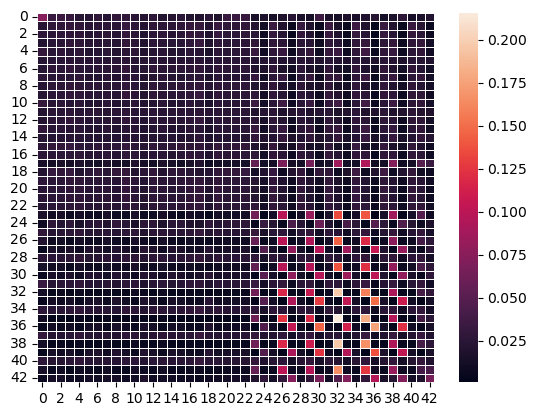

In [24]:
%matplotlib inline
import seaborn as sns
attention_1=attention_collect[0][0,0,:,:].detach().cpu().numpy()

ax = sns.heatmap(attention_1, linewidth=0.5)

plt.show()


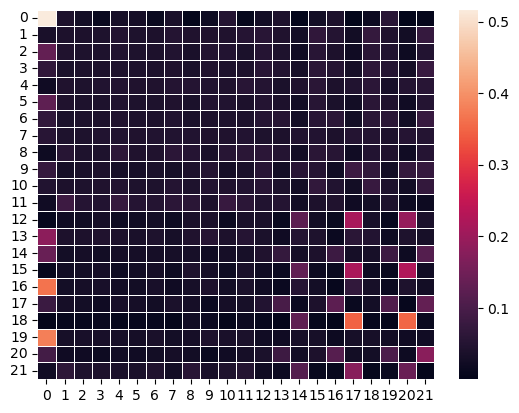

In [25]:
attention_1=attention_collect[1][0,0,:,:].detach().cpu().numpy()

ax = sns.heatmap(attention_1, linewidth=0.5)

plt.show()

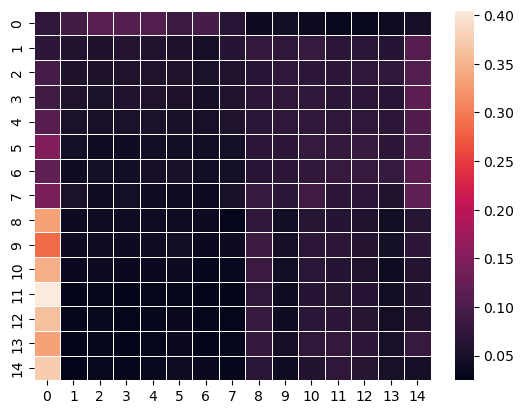

In [26]:
attention_1=attention_collect[2][0,0,:,:].detach().cpu().numpy()

ax = sns.heatmap(attention_1, linewidth=0.5)

plt.show()

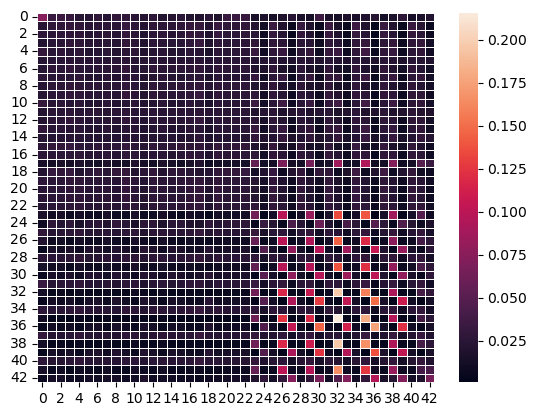

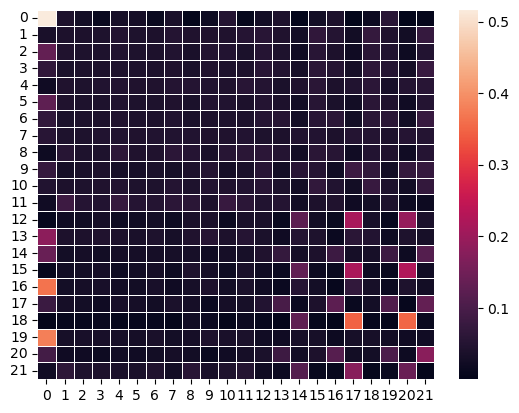

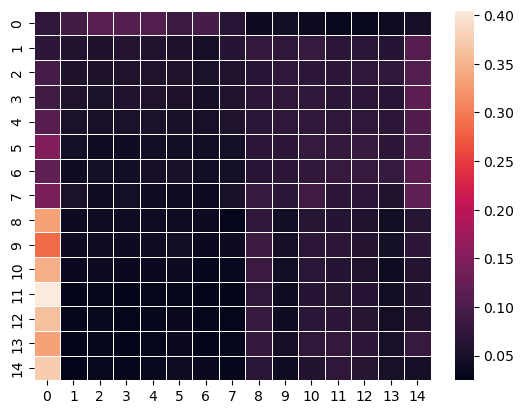

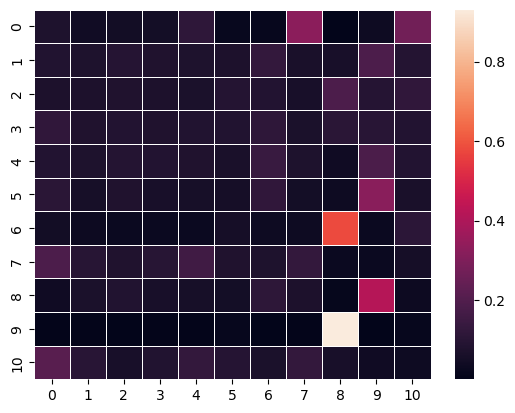

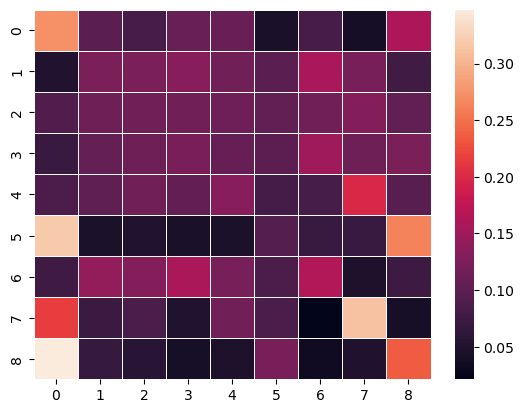

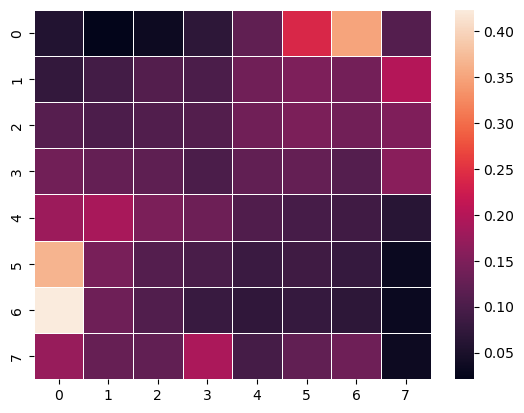

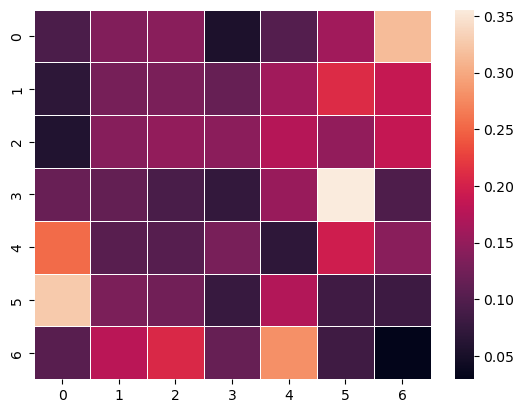

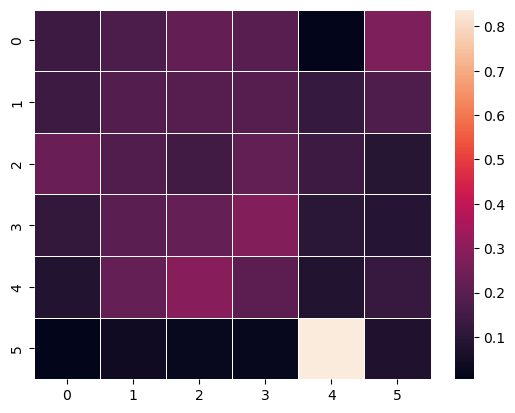

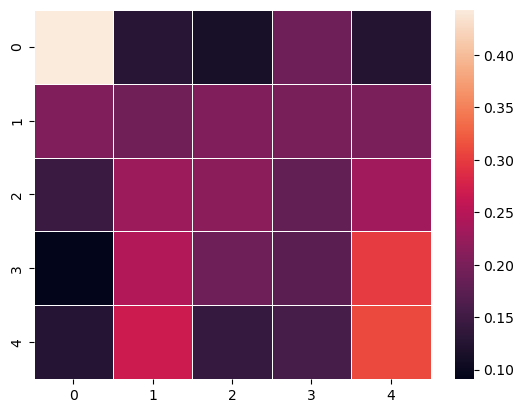

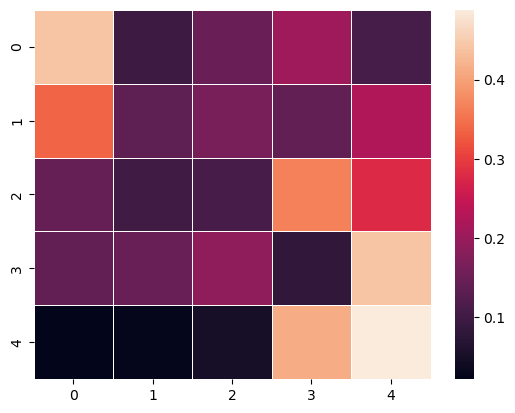

In [27]:
for i in range(10):
    attention_1=attention_collect[i][0,0,:,:].detach().cpu().numpy()

    ax = sns.heatmap(attention_1, linewidth=0.5)

    plt.show()

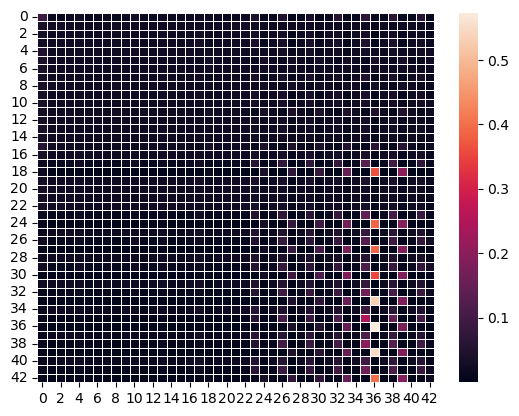

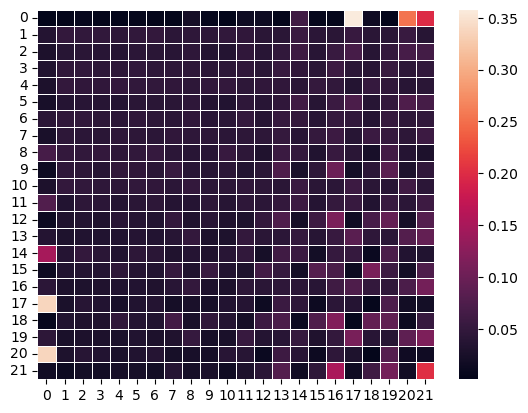

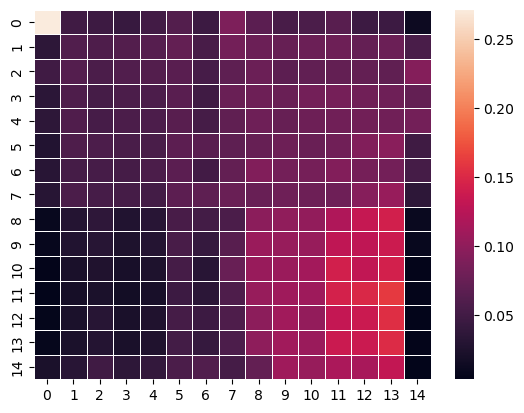

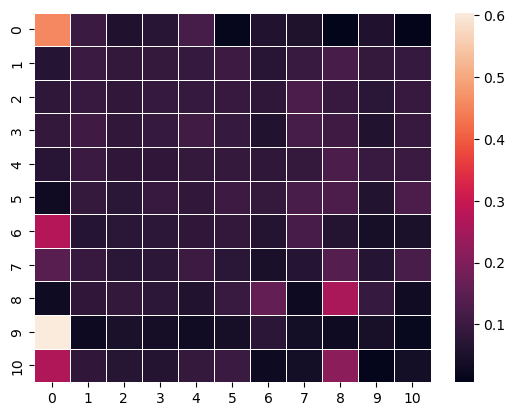

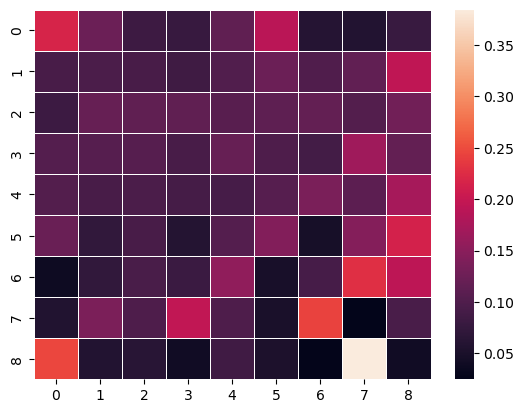

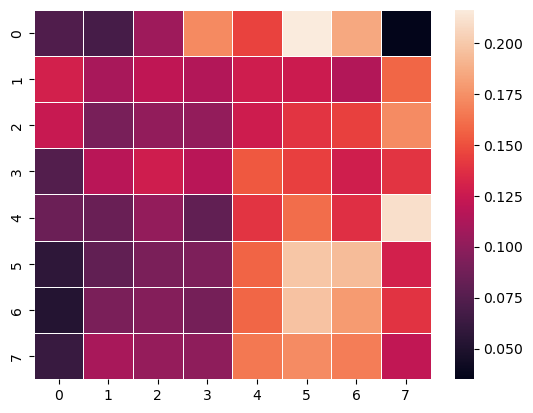

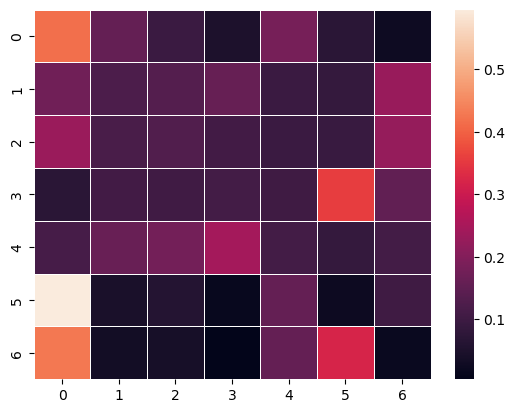

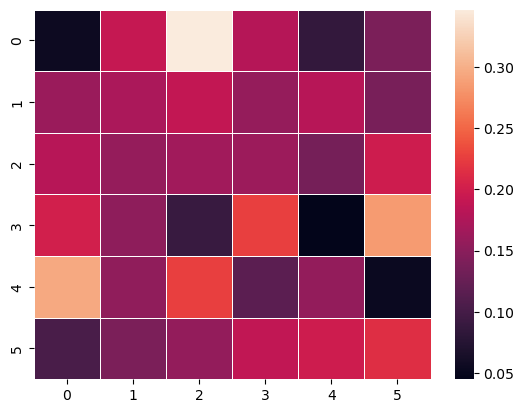

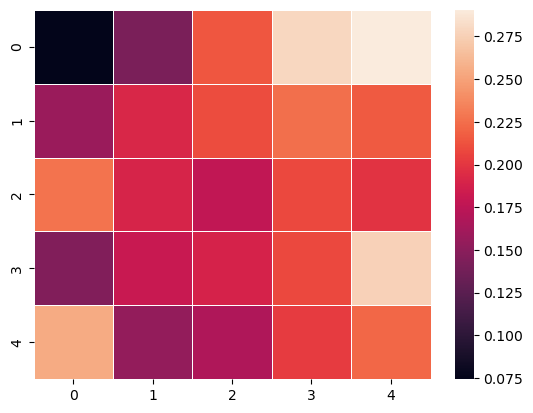

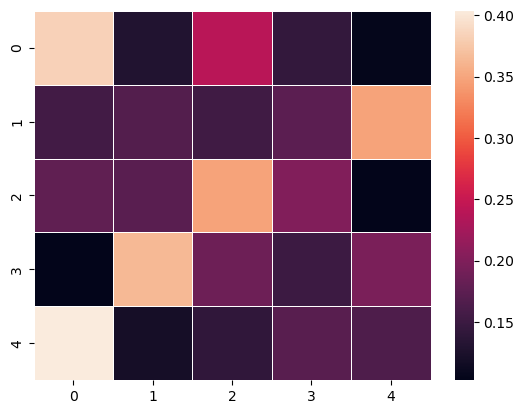

In [28]:
for i in range(10):
    attention_1=attention_collect[i][0,1,:,:].detach().cpu().numpy()

    ax = sns.heatmap(attention_1, linewidth=0.5)

    plt.show()

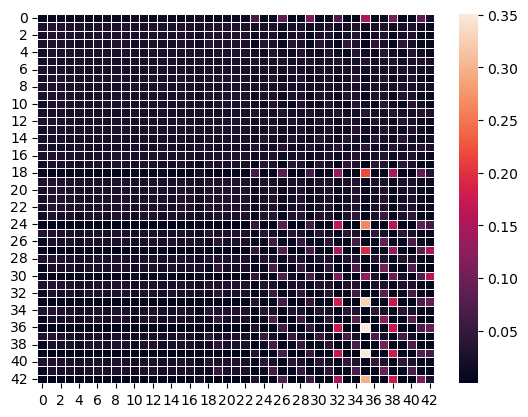

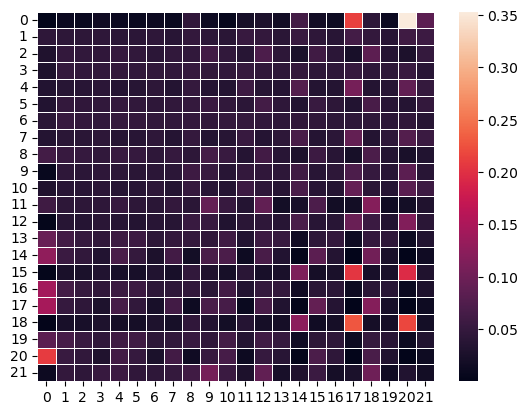

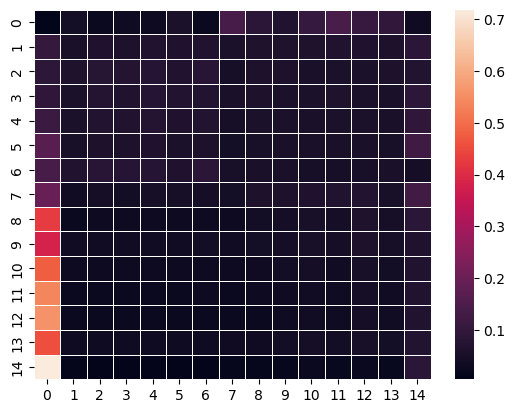

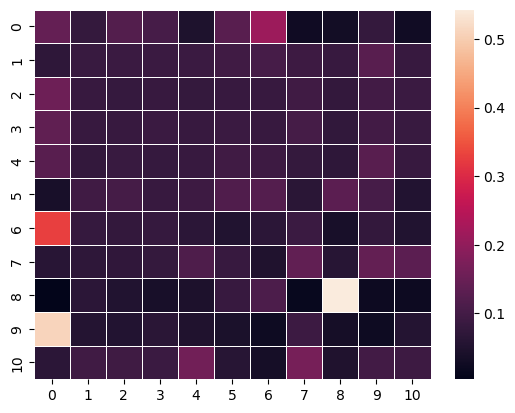

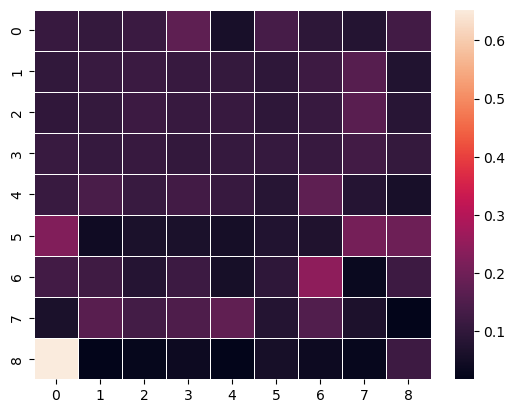

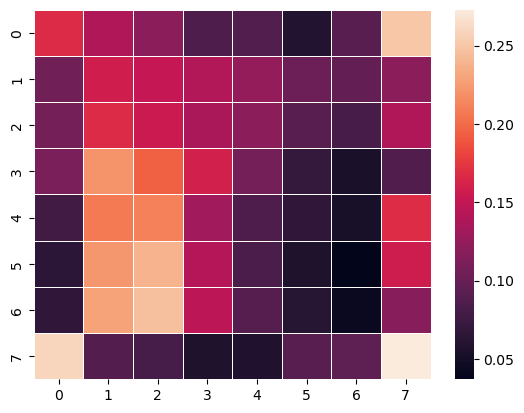

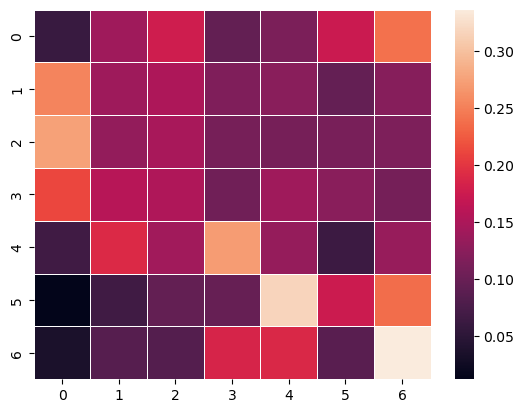

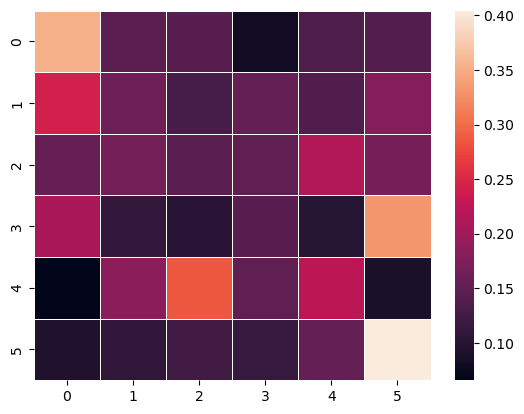

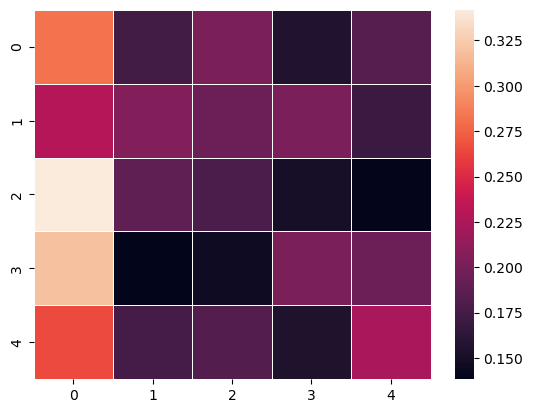

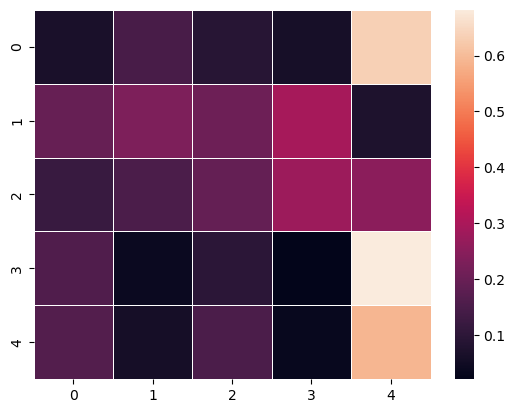

In [29]:
for i in range(10):
    attention_1=attention_collect[i][0,2,:,:].detach().cpu().numpy()

    ax = sns.heatmap(attention_1, linewidth=0.5)

    plt.show()